# Image Multiclassification with Keras: Planet understanding the amazon from space

En este notebook se encuentra el código del modelo realizado utilizando las funciones de la librería Keras de Tensorflow. Además de realizar un modelo multiclasificatorio, otro objetivo es utilizar la librería keras para crear un modelo de redes neuronares convolucionales de cero, es decir, sin utilizar un modelo preentrenado.
 Primero se han procesado y preparado los datos. Despues, se ha definido el arquitectura que va a tener el modelo. A continuación, se ha entrenado el modelo con nuestro dataset. Y, por último se ha realizado la evaluación.

## IMPORTS:

In [1]:
import tensorflow.keras
#keras.__version__
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
import pandas as pd
import tqdm
import numpy as np
#import cv2
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import models
from keras import layers
from tensorflow.keras.applications import resnet
from tqdm import tqdm
import os
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Procesamiento de datos:

Se han tenido bastantes problemas a la hora de procesar los datos debido a como estaban estructurados y porque nosotros teníamos un problema de multiclasificación. 

Como se ha comentado anteriormente en el análisis exploratorio, se tenía un csv que contenía una columna con el nombre de las imágenes y otra con los levels. 

Para adaptar las especificaciones de los argumentos de la función de Keras que generaba y procesaba 
**(train_datagen.flow_from_dataframe)** se ha tenido que cambiar el csv de train.

(Si quieres adaptar el codigo a tu directorio edita la siguiente ruta)

In [2]:
%cd /content/drive/MyDrive/datos_no_est/PRACTICA_IMAGE

/content/drive/MyDrive/datos_no_est/PRACTICA_IMAGE


In [4]:
train = pd.read_csv("data/csv_tags/train_v2.csv")

In [5]:
train['tags'] = train['tags'].str.split(' ')

In [6]:
TAGS = [
    "agriculture",
    "artisinal_mine",
    "bare_ground",
    "blooming",
    "blow_down",
    "clear",
    "cloudy",
    "conventional_mine",
    "cultivation",
    "habitation",
    "haze",
    "partly_cloudy",
    "primary",
    "road",
    "selective_logging",
    "slash_burn",
    "water",
]

In [7]:
for t in TAGS:
  train[t]=0

In [8]:
train

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0,"[haze, primary]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,"[agriculture, clear, primary, water]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,"[clear, primary]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,"[clear, primary]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,"[agriculture, clear, habitation, primary, road]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40474,train_40474,"[clear, primary]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40475,train_40475,[cloudy],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40476,train_40476,"[agriculture, clear, primary]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40477,train_40477,"[agriculture, clear, primary, road]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
def comprobar(df):
  for i in range(len(df)):
    tags = df.iloc[i,1]
    for t in tags:
      train[t][i] = 1

In [10]:
comprobar(train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [11]:
training_data = train.sample(frac=0.8, random_state=25)
validating_data = train.drop(training_data.index)

In [12]:
training_data

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
31650,train_31650,"[clear, primary]",0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
13348,train_13348,"[clear, primary]",0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
27658,train_27658,"[agriculture, clear, cultivation, cultivation,...",1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
34062,train_34062,"[clear, primary]",0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
12999,train_12999,"[clear, primary]",0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35780,train_35780,"[agriculture, clear, habitation, primary, road]",1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0
1424,train_1424,"[clear, primary]",0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
38775,train_38775,"[agriculture, clear, primary, road, water]",1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1
18237,train_18237,"[agriculture, clear, primary]",1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


A pesar de todo este procesamiento, da error cuando se ejecuta las funciones de Keras para procesar y generar los datos. El código era el siguiente.

In [13]:
""" from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        training_data,
        path_train,
        x_col='image_name', y_col=TAGS,
        # This is the target directory
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='multi_output')

validation_generator = test_datagen.flow_from_dataframe(
        validating_data,
        path_train,
        x_col='image_name', y_col=TAGS,
        target_size=(150, 150),
        batch_size=20,
        class_mode='multi_output')"""

" from keras.preprocessing.image import ImageDataGenerator\n\ntrain_datagen = ImageDataGenerator(\n      rescale=1./255,\n      rotation_range=40,\n      width_shift_range=0.2,\n      height_shift_range=0.2,\n      shear_range=0.2,\n      zoom_range=0.2,\n      horizontal_flip=True,\n      fill_mode='nearest')\n\n# Note that the validation data should not be augmented!\n\ntest_datagen = ImageDataGenerator(rescale=1./255)\n\ntrain_generator = train_datagen.flow_from_dataframe(\n        training_data,\n        path_train,\n        x_col='image_name', y_col=TAGS,\n        # This is the target directory\n        # All images will be resized to 150x150\n        target_size=(150, 150),\n        batch_size=20,\n        # Since we use binary_crossentropy loss, we need binary labels\n        class_mode='multi_output')\n\nvalidation_generator = test_datagen.flow_from_dataframe(\n        validating_data,\n        path_train,\n        x_col='image_name', y_col=TAGS,\n        target_size=(150, 150)

También se habia intentado guardar las imágenes en carpetas según sus respectivos labels.

```path_validation ="../data/validation_fotos" ```

```path_train ="../data/train_fotos" ```

In [14]:
def guardar_en_carpetas(path,df):
    l2 = []
    for foto,label in df.values:
        path_fotos="../data/train_jpg"
        for l in label:
            if not os.path.exists(f"{path}/{l}"): os.mkdir(f"{path}/{l}")
            if not os.path.exists( f"{path_train}/{foto}"): l2.append(foto)
      #shutil.move(f"{path_fotos}/{foto}.jpg", f"{path}/{foto}.jpg")
      #if os.path.exists(f"{path}/{foto}"): print("bien!")
    return l2

```fotos_no1 = guardar_en_carpetas(path_validation,validating_data)```

```fotos_no2 = guardar_en_carpetas(path_train,training_data)```

Tampoco en este caso hemos conseguido que funcionara el código de Keras adaptado para que coja las imágenes desde el directorio.

Al final, se decidió que en lugar de procesar imágenes, se procesaría los vectores de las imágenes. Para la variable de y_train se ha definido con label_map.

In [15]:
path_x_train = "data/x_train.npy"
path_y_train = "data/y_train.npy"

if not os.path.exists(path_x_train) and not os.path.exists(path_y_train):
    x_train = []
    x_test = []
    y_train = []
    
    df_train = pd.read_csv('data/csv_tags/train_v2.csv')
    
    flatten = lambda l: [item for sublist in l for item in sublist]
    labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))
    
    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}
    
    for f, tags in tqdm(df_train.values, miniters=1000):
        img = cv2.imread('data/train-jpg/{}.jpg'.format(f))
        targets = np.zeros(17)
        for t in tags.split(' '):
            targets[label_map[t]] = 1 
        x_train.append(cv2.resize(img, (32, 32)))
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    x_train = np.array(x_train, np.float16) / 255.
    
    print(x_train.shape)
    print(y_train.shape)
    
    with open(path_x_train, 'wb') as f:
        np.save(f, x_train)
    with open(path_y_train, 'wb') as f:
        np.save(f, y_train)

In [16]:
%ls

 amazon_forest_notebook.ipynb
'Copia de 9_IMAGE_Pretrained-convnet.ipynb'
 data/
 keras.ipynb
 planet-understanding-the-amazon-from-space/
 __Untitled0.ipynb
 Untitled0.ipynb


Se carga los array de y_train y x_train.

In [4]:
with open('data/x_train.npy', 'rb') as f:
    x_train = np.load(f)
with open('data/y_train.npy', 'rb') as f:
    y_train = np.load(f)

In [31]:
x_train

array([[[[0.396  , 0.4314 , 0.3647 ],
         [0.4236 , 0.451  , 0.4    ],
         [0.4    , 0.4353 , 0.3765 ],
         ...,
         [0.396  , 0.4275 , 0.349  ],
         [0.4    , 0.4119 , 0.3452 ],
         [0.408  , 0.4314 , 0.3765 ]],

        [[0.408  , 0.4236 , 0.3647 ],
         [0.4119 , 0.4353 , 0.3765 ],
         [0.4038 , 0.4275 , 0.3765 ],
         ...,
         [0.4158 , 0.443  , 0.3647 ],
         [0.408  , 0.4314 , 0.3608 ],
         [0.396  , 0.4236 , 0.3452 ]],

        [[0.4    , 0.4197 , 0.3608 ],
         [0.4038 , 0.4314 , 0.3765 ],
         [0.4197 , 0.4548 , 0.4038 ],
         ...,
         [0.4    , 0.4197 , 0.3647 ],
         [0.4197 , 0.4392 , 0.3647 ],
         [0.392  , 0.4119 , 0.3372 ]],

        ...,

        [[0.4158 , 0.4548 , 0.3843 ],
         [0.4158 , 0.451  , 0.3608 ],
         [0.4038 , 0.4314 , 0.349  ],
         ...,
         [0.4    , 0.4314 , 0.3452 ],
         [0.4038 , 0.4236 , 0.3452 ],
         [0.4119 , 0.4236 , 0.349  ]],

        [[

Aqui, se separa los datos en train, test y validation.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

x_train, x_val, y_train, y_val  = train_test_split(x_train, y_train, test_size=0.2, random_state=1) 

In [6]:
print(len(x_train) , len(x_val) , len(x_test))

29144 7287 4048


## Arquitectura del modelo:

Hemos probado dos input_size (82,82) y (32,32). Entendemos que tendrá que dar mejor resultado el size más pequeño ya que el modelo aprende más facil. Aun asi, los resultados no lo reflejan.

Como se ha comentado anteriormente, se quiere crear un modelo de cero.

Al modelo, primero se ha decidido añadir una capa convolucional de 32 filtros con una size del kernel de 3x3, la función de activación es relu y también se define el input_shape de 82x82.

Despues, se añade otra capa convlucional pero esta de 64 filtros.

Luego se realiza el MaxPooling para quedarnos con la imformación que más importe.

Para evitar sobreentrenamiento hemos añadido una capa de Dropout.

Despues añadimos una capa Dense de 128 con una función de activación de relu.

Añadimos otra capa Dropout por la mimsma razón que la de antes.

Por último, añadimos la ultima capa Dense de 17 (como el número de labels) y de función de activación de Softmax.

In [21]:
model = models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(82, 82, 3)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17, activation='sigmoid'))

This is what our model looks like now:

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 78, 78, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 39, 39, 64)        0         
                                                                 
 flatten (Flatten)           (None, 97344)             0         
                                                                 
 dense (Dense)               (None, 128)               12460160  
                                                        

# Entrenar el modelo con nuestro Dataset

Se ha definido la variable callbacks para definir el Early Stopping y para que guarde los weights.

In [9]:
history = History()
callbacks = [history, 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ModelCheckpoint(filepath='data/weights.best.hdf5', verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='auto')]

Ahora, es el momento de entrenar el modelo. Se ha utilizado el optamizer de Adam.

In [24]:
model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['acc'])
              
model.fit(x_train, y_train,
          batch_size=128,
          epochs=4,
          verbose=1,
          validation_data=(x_val, y_val),
          callbacks = callbacks)

Epoch 1/10
228/228 [==============================] - ETA: 0s - loss: 0.2680 - acc: 0.6812
Epoch 1: val_loss improved from inf to 0.20819, saving model to data/weights.best.hdf5
228/228 [==============================] - 43s 139ms/step - loss: 0.2680 - acc: 0.6812 - val_loss: 0.2082 - val_acc: 0.7508
Epoch 2/10
228/228 [==============================] - ETA: 0s - loss: 0.2193 - acc: 0.7324
Epoch 2: val_loss improved from 0.20819 to 0.19361, saving model to data/weights.best.hdf5
228/228 [==============================] - 28s 123ms/step - loss: 0.2193 - acc: 0.7324 - val_loss: 0.1936 - val_acc: 0.7566
Epoch 3/10
228/228 [==============================] - ETA: 0s - loss: 0.2052 - acc: 0.7311
Epoch 3: val_loss improved from 0.19361 to 0.18397, saving model to data/weights.best.hdf5
228/228 [==============================] - 28s 125ms/step - loss: 0.2052 - acc: 0.7311 - val_loss: 0.1840 - val_acc: 0.7475
Epoch 4/10
228/228 [==============================] - ETA: 0s - loss: 0.1965 - acc: 0.

In [25]:
from matplotlib import pyplot as plt

In [26]:
history.history

{'acc': [0.6811693906784058,
  0.7324320673942566,
  0.7310595512390137,
  0.7270449995994568,
  0.7262901663780212,
  0.7282116413116455,
  0.7245745062828064,
  0.7151729464530945,
  0.7121191620826721,
  0.7064576148986816],
 'loss': [0.2680439352989197,
  0.219281405210495,
  0.20520532131195068,
  0.1964750736951828,
  0.19070544838905334,
  0.18534459173679352,
  0.179092675447464,
  0.17607200145721436,
  0.1706428825855255,
  0.1671372652053833],
 'val_acc': [0.7507891058921814,
  0.7565527558326721,
  0.7474955320358276,
  0.7469466328620911,
  0.7366543412208557,
  0.7435158491134644,
  0.7538081407546997,
  0.7529847621917725,
  0.7474955320358276,
  0.7157952785491943],
 'val_loss': [0.20819461345672607,
  0.19360828399658203,
  0.18396662175655365,
  0.17869816720485687,
  0.17376074194908142,
  0.1743645966053009,
  0.16557817161083221,
  0.16248342394828796,
  0.16029202938079834,
  0.16149409115314484]}

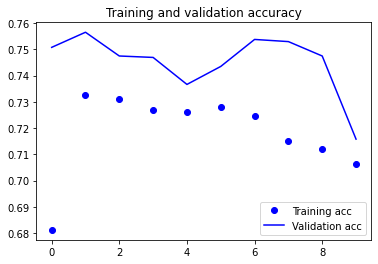

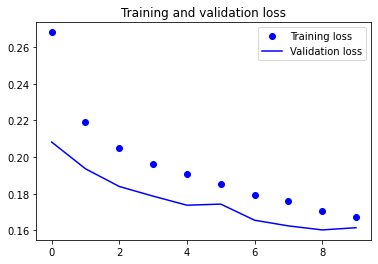

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluación:

In [28]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('test acc:', test_acc)

127/127 - 2s - loss: 0.1624 - acc: 0.7189 - 2s/epoch - 16ms/step
test acc: 0.7188735008239746


Aun probando diferentes parametros, no hemos conseguido subir más el accuracy. Por eso tratamos de disminuir el input_size para que el modelo aprendiese mejor. 

# Entrenar el modelo con size (32,32)

In [3]:
with open('data/x_train_32.npy', 'rb') as f:
    x_train = np.load(f)
with open('data/y_train_32.npy', 'rb') as f:
    y_train = np.load(f)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

x_train, x_val, y_train, y_val  = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [5]:
model2 = models.Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(32, 32, 3)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Dropout(0.25))
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(17, activation='sigmoid'))

In [6]:
history = History()
callbacks = [history, 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ModelCheckpoint(filepath='data/weights.best.hdf5', verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='auto')]

In [7]:
model2.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['acc'])
              
model2.fit(x_train, y_train,
          batch_size=128,
          epochs=4,
          verbose=1,
          validation_data=(x_val, y_val),
          callbacks = callbacks)

Epoch 1/4
228/228 [==============================] - ETA: 0s - loss: 0.2566 - acc: 0.0221
Epoch 1: val_loss improved from inf to 0.20760, saving model to data/weights.best.hdf5
228/228 [==============================] - 7s 23ms/step - loss: 0.2566 - acc: 0.0221 - val_loss: 0.2076 - val_acc: 0.0224
Epoch 2/4
226/228 [============================>.] - ETA: 0s - loss: 0.2113 - acc: 0.0252
Epoch 2: val_loss improved from 0.20760 to 0.19020, saving model to data/weights.best.hdf5
228/228 [==============================] - 4s 20ms/step - loss: 0.2112 - acc: 0.0252 - val_loss: 0.1902 - val_acc: 0.0232
Epoch 3/4
226/228 [============================>.] - ETA: 0s - loss: 0.1989 - acc: 0.0325
Epoch 3: val_loss improved from 0.19020 to 0.18013, saving model to data/weights.best.hdf5
228/228 [==============================] - 4s 20ms/step - loss: 0.1987 - acc: 0.0325 - val_loss: 0.1801 - val_acc: 0.0309
Epoch 4/4
226/228 [============================>.] - ETA: 0s - loss: 0.1882 - acc: 0.0398
Epoch

Como se observa, el accuracy en el modelo donde se ha realizado un resize de 32x32 es muy bajo. No hemos tenido tiempo de averiguar la razón. Como pasos futuros se podría analizar en más profundidad.